<a href="https://colab.research.google.com/github/rickiepark/MLQandAI/blob/main/supplementary/q25_confidence-intervals/2_four-methods-vs-true-value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CI Simulation

In [1]:
!pip install --quiet watermark

%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p numpy,mlxtend,matplotlib,sklearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.9 MB/s eta 0:00:00
Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 7.34.0

numpy     : 1.26.4
mlxtend   : 0.23.3
matplotlib: 3.10.0
sklearn   : 1.6.0



- 이 노트북은 [1_four-methods](1_four-methods)의 보조 노트북으로 가상의 예제를 다룹니다.
- 여기서는 실제 모델 정확도(일반화 정확도)가 신뢰 구간 안에 포함되는지 알아 보겠습니다.
- 이를 위해 10,002,000개의 데이터 포인트로 구성된 분류용 합성 데이터셋을 만듭니다.

## 대규모 합성 훈련 데이터와 테스트 데이터

In [2]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=10_002_000,
    n_features=12,
    n_redundant=5,
    n_classes=2,
    random_state=123,
    flip_y=0.25,
)

In [3]:
X_train = X[:1_000]
y_train = y[:1_000]

X_test = X[1_000:2_000]
y_test = y[1_000:2_000]

X_huge_test = X[2_000:]
y_huge_test = y[2_000:]

- 처음 1,000개의 데이터 포인트를 훈련에 사용하고, 두 번째 1,000개의 데이터 포인트는 테스트에 사용합니다. 남은 10,000,000개 데이터 포인트를 사용해 모델의 실제 성능을 계산합니다.

## 실제 일반화 성능

In [4]:
from sklearn.neural_network import MLPClassifier


clf = MLPClassifier(
    hidden_layer_sizes=(10,),
    activation="relu",
    learning_rate_init=0.01,
    random_state=123,
    solver="adam",
    max_iter=500
)

clf.fit(X_train, y_train)

acc_test_true = clf.score(X_huge_test, y_huge_test)
acc_test_true

0.7882329

## 1) 테스트 세트 기반의 정규 근사 구간

In [5]:
import numpy as np
import scipy.stats

confidence = 0.95  # 원하는 신뢰 수준으로 바꾸세요.
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)


clf.fit(X_train, y_train)

acc_test = clf.score(X_test, y_test)
ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

ci_lower = acc_test - ci_length
ci_upper = acc_test + ci_length

print(ci_lower, ci_upper)

0.7720698282384794 0.8219301717615207


In [6]:
results = {
    "Method 1: Normal approximation": {
        "Test accuracy": acc_test,
        "Lower 95% CI": ci_lower,
        "Upper 95% CI": ci_upper,
    }
}

## 2) 훈련 세트 부트스트래핑하기

In [7]:
import numpy as np

rng = np.random.RandomState(seed=12345)
idx = np.arange(y_train.shape[0])

bootstrap_train_accuracies = []
bootstrap_rounds = 200


for i in range(bootstrap_rounds):

    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    valid_idx = np.setdiff1d(idx, train_idx, assume_unique=False)

    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]
    boot_valid_X, boot_valid_y = X_train[valid_idx], y_train[valid_idx]

    clf.fit(boot_train_X, boot_train_y)
    acc = clf.score(boot_valid_X, boot_valid_y)
    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)
bootstrap_train_mean

0.769659240981034

- 부트스트래핑 테스트 정확도($ \text{ACC}_{\text{boot}, j}$)와 샘플 평균($\text{ACC}_{\text{bootavg}}$)을 히스토그램으로 시각화합니다:

#### 백분위 방법 사용하기

In [8]:
ci_lower = np.percentile(bootstrap_train_accuracies, 2.5)
ci_upper = np.percentile(bootstrap_train_accuracies, 97.5)

print(ci_lower, ci_upper)

0.7280214285714285 0.8092909569699687


- Let's have a look how it looks like in the context of our

In [9]:
results["Method 2: Bootstrap, percentile"] = {
    "Test accuracy": bootstrap_train_mean,
    "Lower 95% CI": ci_lower,
    "Upper 95% CI": ci_upper,
}

## 3) 테스트 세트 예측 부트스트래핑하기

In [10]:
clf.fit(X_train, y_train)

predictions_test = clf.predict(X_test)
acc_test = np.mean(predictions_test == y_test)

rng = np.random.RandomState(seed=12345)
idx = np.arange(y_test.shape[0])

test_accuracies = []

for i in range(200):

    pred_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    acc_test_boot = np.mean(predictions_test[pred_idx] == y_test[pred_idx])
    test_accuracies.append(acc_test_boot)

bootstrap_train_mean = np.mean(test_accuracies)
bootstrap_train_mean

0.7963800000000001

- 백분위 방법을 사용해 신뢰 구간을 얻을 수 있습니다::

In [11]:
ci_lower = np.percentile(test_accuracies, 2.5)
ci_upper = np.percentile(test_accuracies, 97.5)

print(ci_lower, ci_upper)

0.768 0.825


In [12]:
results["Method 3: Bootstrap test set"] = {
    "Test accuracy": bootstrap_train_mean,
    "Lower 95% CI": ci_lower,
    "Upper 95% CI": ci_upper,
}

## 4) 다른 랜덤 시드로 모델을 재훈련하기

In [13]:
test_accuracies = []
rounds = 5


for i in range(rounds):

    clf = MLPClassifier(
        hidden_layer_sizes=(10,),
        activation="relu",
        learning_rate_init=0.01,
        random_state=i,  # 랜덤 시드만 수정합니다.
        solver="adam",
        max_iter=500
)

    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    test_accuracies.append(acc)

test_mean = np.mean(test_accuracies)
test_mean

0.7934

In [14]:
confidence = 0.95  # 원하는 신뢰 수준으로 바꾸세요.
t_value = scipy.stats.t.ppf((1 + confidence) / 2.0, df=rounds - 1)

sd = np.std(test_accuracies, ddof=1)
se = sd / np.sqrt(rounds)

ci_length = t_value * se

ci_lower = test_mean - ci_length
ci_upper = test_mean + ci_length

print(ci_lower, ci_upper)

0.7838787766707844 0.8029212233292156


In [15]:
results["Method 4: Random seeds"] = {
    "Test accuracy": test_mean,
    "Lower 95% CI": ci_lower,
    "Upper 95% CI": ci_upper,
}

## 여러 신뢰 구간 방법 비교하기


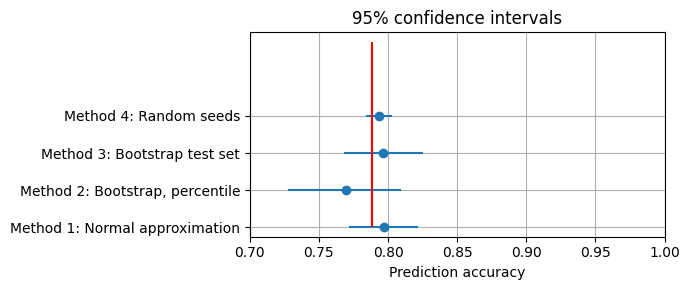

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

labels = list(results.keys())

means = np.array([results[k]["Test accuracy"] for k in labels])
lower_error = np.array([results[k]["Lower 95% CI"] for k in labels])
upper_error = np.array([results[k]["Upper 95% CI"] for k in labels])

asymmetric_error = [means - lower_error, upper_error - means]


fig, ax = plt.subplots(figsize=(7, 3))
ax.errorbar(means, np.arange(len(means)), xerr=asymmetric_error, fmt="o")
ax.set_xlim([0.7, 1.0])
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(labels)
ax.set_xlabel("Prediction accuracy")
ax.set_title("95% confidence intervals")

ax.vlines(acc_test_true, [0], 5, lw=1.5, color="red", linestyle="-", label="True value")

plt.grid()
plt.tight_layout()
plt.show()